In [2]:
%matplotlib inline

In [ ]:
"""
Plotting the Aurora Forecast from NOAA on Orthographic Polar Projection
-----------------------------------------------------------------------
Data is provided as a 1024 by 512 grid of probabilities in percent of visible aurora. 
The data is spaced equally in degrees from -180 to 180 and -90 to 90.
"""

import cartopy.crs as ccrs
from datetime import datetime
from io import StringIO
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen

In [ ]:
def aurora_forecast():
    """
    Gets the latest Aurora Forecast from http://swpc.noaa.gov.

    Returns
    -------
    img : numpy array
        The pixels of the image in a numpy array.
    img_proj : cartopy CRS
        The rectangular coordinate system of the image.
    img_extent : tuple of floats
        The extent of the image ``(x0, y0, x1, y1)`` referenced in
        the ``img_proj`` coordinate system.
    origin : str
        The origin of the image to be passed through to matplotlib's imshow.
    dt : datetime
        Time of forecast validity.

    """

    # GitHub gist to download the example data from
    url = ('https://gist.githubusercontent.com/belteshassar/'
           'c7ea9e02a3e3934a9ddc/raw/aurora-nowcast-map.txt')
    # Read the .txt file, which is the 1024x512 grid of probabilities
    response_text = StringIO(urlopen(url).read().decode('utf-8'))
    img = np.loadtxt(response_text) # All lines must be of same length for loadtxt to work
    
    # Read forecast date and time (because we know what the file looks like...)
    response_text.seek(0)
    for line in response_text:
        if line.startswith('Product Valid At:', 2):
            dt = datetime.strptime(line[-17:-1], '%Y-%m-%d %H:%M')

    img_proj = ccrs.PlateCarree()
    img_extent = (-180, 180, -90, 90)
    return img, img_proj, img_extent, 'lower', dt

In [16]:
# GitHub gist to download the example data from
url = ('https://gist.githubusercontent.com/belteshassar/'
       'c7ea9e02a3e3934a9ddc/raw/aurora-nowcast-map.txt')
# Read the .txt file, which is the 1024x512 grid of probabilities
response_text = StringIO(urlopen(url).read().decode('utf-8'))

In [17]:
for line in response_text:
    print(line)

#Aurora Specification Tabular Values

# Product: Ovation Aurora Short Term Forecast    <path to tabular data>

# Product Valid At: 2016-03-15 06:25

# Product Generated At: 2016-03-15 05:55

#

# Prepared by the U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center.

# Please send comments and suggestions to SWPC.Webmaster@noaa.gov

#

# Missing Data:  (n/a)

# Cadence:   5 minutes

#

# Tabular Data is on the following grid

#

#   1024 values covering 0 to 360 degrees in the horizontal (longitude) direction  (0.32846715 degrees/value)

#   512 values covering -90 to 90 degrees in the vertical (latitude) direction  (0.3515625 degrees/value)

#   Values range from 0 (little or no probability of visible aurora) to 100 (high probability of visible aurora)

#

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

In [ ]:
def aurora_cmap():
    """Return a colormap with aurora like colors"""
    stops = {'red': [(0.00, 0.1725, 0.1725),
                     (0.50, 0.1725, 0.1725),
                     (1.00, 0.8353, 0.8353)],

             'green': [(0.00, 0.9294, 0.9294),
                       (0.50, 0.9294, 0.9294),
                       (1.00, 0.8235, 0.8235)],

             'blue': [(0.00, 0.3843, 0.3843),
                      (0.50, 0.3843, 0.3843),
                      (1.00, 0.6549, 0.6549)],

             'alpha': [(0.00, 0.0, 0.0),
                       (0.50, 1.0, 1.0),
                       (1.00, 1.0, 1.0)]}

    return LinearSegmentedColormap('aurora', stops)

In [22]:
def sun_pos(dt=None):
    """This function computes a rough estimate of the coordinates for
    the point on the surface of the Earth where the Sun is directly
    overhead at the time dt. Precision is down to a few degrees. This
    means that the equinoxes (when the sign of the latitude changes)
    will be off by a few days.

    The function is intended only for visualization. For more precise
    calculations consider for example the PyEphem package.

    Parameters
    ----------
        dt: datetime
            Defaults to datetime.utcnow()

    Returns
    -------
        lat, lng: tuple of floats
            Approximate coordinates of the point where the sun is
            in zenith at the time dt.
    """
    if dt is None:
        dt = datetime.utcnow()

    axial_tilt = 23.4
    ref_solstice = datetime(2016, 6, 21, 22, 22)
    days_per_year = 365.2425
    seconds_per_day = 24*60*60.0

    days_since_ref = (dt - ref_solstice).total_seconds()/seconds_per_day
    lat = axial_tilt*np.cos(2*np.pi*days_since_ref/days_per_year)
    sec_since_midnight = (dt - datetime(dt.year, dt.month, dt.day)).seconds
    lon = -(sec_since_midnight/seconds_per_day - 0.5)*360
    return lat, lon

In [ ]:
def fill_dark_side(ax, time=None, *args, **kwargs):
    """
    Plot a fill on the dark side of the planet (without refraction).

    Parameters
    ----------
        ax : matplotlib axes
            The axes to plot on.
        time : datetime
            The time to calculate terminator for. Defaults to datetime.utcnow()
        **kwargs :
            Passed on to Matplotlib's ax.fill()

    """
    lat, lng = sun_pos(time)
    pole_lng = lng
    if lat > 0:
        pole_lat = -90 + lat
        central_rot_lng = 180
    else:
        pole_lat = 90 + lat
        central_rot_lng = 0

    rotated_pole = ccrs.RotatedPole(pole_latitude=pole_lat,
                                    pole_longitude=pole_lng,
                                    central_rotated_longitude=central_rot_lng)

    x = np.empty(360)
    y = np.empty(360)
    x[:180] = -90
    y[:180] = np.arange(-90, 90.)
    x[180:] = 90
    y[180:] = np.arange(90, -90., -1)

    ax.fill(x, y, transform=rotated_pole, **kwargs)

In [20]:
def main():
    fig = plt.figure(figsize=[10, 5])

    # We choose to plot in an Orthographic projection as it looks natural
    # and the distortion is relatively small around the poles where
    # the aurora is most likely.

    # ax1 for Northern Hemisphere
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

    # ax2 for Southern Hemisphere
    ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

    img, crs, extent, origin, dt = aurora_forecast()

    for ax in [ax1, ax2]:
        ax.coastlines(zorder=3)
        ax.stock_img()
        ax.gridlines()
        fill_dark_side(ax, time=dt, color='black', alpha=0.75)
        ax.imshow(img, vmin=0, vmax=100, transform=crs,
                  extent=extent, origin=origin, zorder=2,
                  cmap=aurora_cmap())

    plt.show()

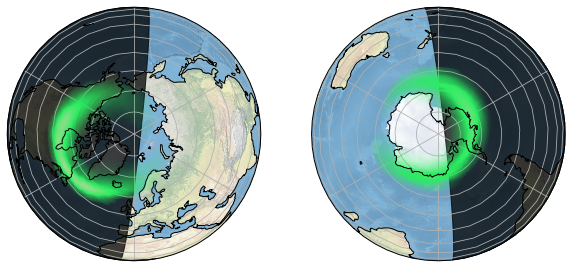

In [23]:
if __name__ == '__main__':
    main()

In [ ]:
# GitHub gist to download the example data from
url = ('https://gist.githubusercontent.com/belteshassar/'
       'c7ea9e02a3e3934a9ddc/raw/aurora-nowcast-map.txt')
# Read the .txt file, which is the 1024x512 grid of probabilities
response_text = StringIO(urlopen(url).read().decode('utf-8'))
img = np.loadtxt(response_text) # All lines must be of same length for loadtxt to work

# Read forecast date and time (because we know what the file looks like...)
response_text.seek(0)
for line in response_text:
    if line.startswith('Product Valid At:', 2):
        dt = datetime.strptime(line[-17:-1], '%Y-%m-%d %H:%M')

img_proj = ccrs.PlateCarree()
img_extent = 

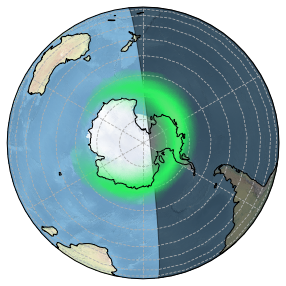

In [43]:
import matplotlib.path as mpath

fig = plt.figure(figsize=[10, 5])
# ax2 for Southern Hemisphere
ax2 = plt.subplot(projection=ccrs.Orthographic(180, -90))

ax2.coastlines(zorder=3)
ax2.stock_img()
ax2.gridlines(linestyle='--')
fill_dark_side(ax2, time=dt, color='black', alpha=0.5)

# vmin & vmax control the minimum & maximum values showed
ax2.imshow(img, vmin=0, vmax=100, transform=ccrs.PlateCarree(),
          origin='lower', zorder=2,
          cmap=aurora_cmap())

plt.show()